In [1]:
# Jadie Adams

import numpy as np
import math
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
font = {'size'   : 16}
plt.rc('font', **font)

import LDS_model
import utils

angles = np.arange(0, 2*np.pi, np.pi/4) + 0.5 # for 8 correspondences 

# Ellipse Data

In [2]:
# Define dimensions
N = 100 # number of samples
d = 2 # dimension of correspondence points
M = 8 # number of correspondence points
L = 2 # dimension of latent space
P = d*M  # dimension of observation space 
T = 24   # number of time points
period = 8

In [3]:
'''
Input: N - number of samples, T - number of time points
Output: Generated data with shape (N, T, P) where P = dM (here d is 2 and M is 9)
'''
def generate_ellipse_data(N=3, T=16, period=8, x_radius_std=0.2, noise_std=0.01, plot=False):
    # Major radius random value between 2 and 4 
    # Minor radius varies between 1 and 3 on a sin wave dependent on t
    data = []
    if plot:
        plt_x = []
        plt_y = []
    for sample_index in range(N):
        data.append([])
        major_radius = np.random.normal(0.6, x_radius_std)/3
        # clip
        if major_radius < 0:
            major_radius = 0
        if major_radius > 1:
            major_radius =1
        x_values = major_radius*np.cos(angles)
        for i in range(T):
            minor_diameter = 0.4*np.sin(i*(2*np.pi/period)) + 0.6 #between 1 and .2
            minor_radius = minor_diameter/2
            y_values = minor_radius*np.sin(angles)
            data[sample_index].append([x_values,y_values])
    data = np.asarray(data, np.float32)
    # Add noise
    data = data.reshape(N, T, 2*len(angles))
    data = data + np.random.normal(0, noise_std, data.shape)
    
    if plot:
        data2 = data.reshape(N, T, 2, len(angles))
        plt_x = data2[:,:,0,:]
        plt_y = data2[:,:,1,:]
        plt.figure(figsize=(100, 30))
        dim = math.ceil(T/8)
        I = 3
        J = min(16,len(plt_x[0]))
        fig, axs = plt.subplots(I, J, figsize=(J,I+1))
        for ax in axs.flat:
            ax.set_xlim([-0.5, 0.5])
            ax.set_ylim([-0.5, 0.5])
            ax.label_outer()
        row = 0
        colors = ['b', 'teal', 'g', 'y', 'orange', 'r', 'pink', 'm', 'c']
        for i in range(I):
            for j in range(J):
                for p in range(len(plt_x[i][j])):
                    axs[row][j].scatter(plt_x[i][j][p], plt_y[i][j][p], color=colors[p])
                axs[0][j].set_title('t =' + str(j+1))
            row += 1
        plt.show()
    return data

<Figure size 7200x2160 with 0 Axes>

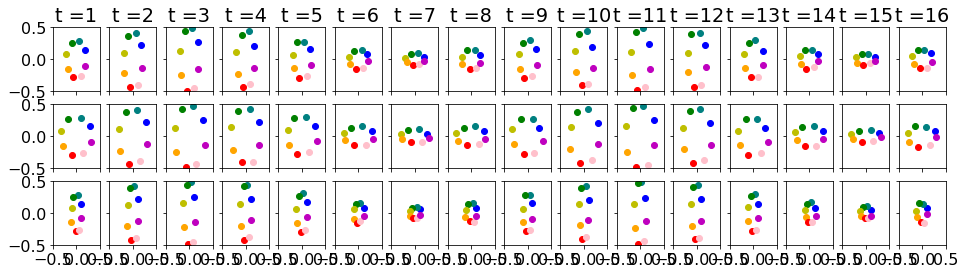

In [4]:
# Generate data
X = generate_ellipse_data(N, T, period, plot=True)

In [5]:
# Generate test data
test_obs = generate_ellipse_data(100, T, period, plot=False)

# Helper and Plotting Functions

In [72]:
# obs has shape (T, dM)
def plot_obs(obs, mask=None):
    obs = obs.reshape(T, d, M)
    plt.figure(figsize=(100, 50))
    dim = math.ceil(T/8)
    J = min(8,len(obs))
    fig, axs = plt.subplots(1, J, figsize=(J,1))
    for ax in axs.flat:
        ax.set_xlim([-0.5,0.5])
        ax.set_ylim([-0.5,0.5])
        ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
#         ax.label_outer()
    colors = ['b', 'teal', 'g', 'y', 'orange', 'r', 'pink', 'm', 'c']
    for j in range(J):
        # Shade if missing
        if mask is not None:
            if mask[j][0]:
                axs[j].patch.set_facecolor('gray')
        for p in range(len(obs[j][0])):
            axs[j].scatter(obs[j][0][p], obs[j][1][p], color=colors[p])

                
#         axs[j].set_title('t =' + str(j+1))
    plt.show()

In [81]:
def box_plots(MSES):
    labels = []
    for i in range(MSES.shape[1]):
        labels.append("T="+str(i+1))
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(MSES)
    plt.xlabel("Time Point")
    plt.ylabel("MSE")

In [8]:
def get_radius(obs):
    obs = obs.reshape(obs.shape[0], obs.shape[1], 2, int(obs.shape[-1]/2))
    y_rad = []
    rads = []
    for sample_index in range(obs.shape[0]):
        x_values = obs[sample_index, :, 0, :]
        y_values = obs[sample_index, :, 1, :]
        for i in range(x_values.shape[0]):
            rads.append([np.mean(x_values[i]/np.cos(angles)), np.mean(y_values[i]/np.sin(angles))])
    rads = np.array(rads)
    rads[rads<0]=0
    rads[rads>0.65]=0.65
    return np.array(rads)

In [9]:
def violin_radius(rads, rads2, label1="group1", label2="group2"):
    rads = rads.flatten()
    rads2 = rads2.flatten()
    combined_rads = np.zeros(rads.shape[0]+rads2.shape[0])
    combined_rads[:rads.shape[0]] = rads
    combined_rads[rads.shape[0]:] = rads2
    groups = [label2] * combined_rads.shape[0]
    labels = []
    for i in range(rads.shape[0]):
        groups[i] = label1
        labels.append('x-radius')
        labels.append('y-radius')

    data = {'Data Type':groups, 'Radius':labels, "Radius Values":combined_rads}
    df = pd.DataFrame(data) 
    sns.set_style("whitegrid")
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    ax = sns.violinplot(x=df['Radius Values'], y=labels, hue=groups,
                        data=df, palette="Set2", split=True, scale="area", ax=ax)

In [10]:
def sample_accuracy(samples):
    rads = get_radius(samples).reshape((samples.shape[0], samples.shape[1], 2))    
    expected = []
    for sample_index in range(rads.shape[0]):
        expected.append([])
        major_radius = np.mean(rads[sample_index,:,0])
        # clip
        if major_radius < 0:
            major_radius = 0
        x_values = major_radius*np.cos(angles)
        for i in range(T):
            minor_diameter = 0.4*np.sin(i*(2*np.pi/period)) + 0.6 #between 1 and .2
            minor_radius = minor_diameter/2
            y_values = minor_radius*np.sin(angles)
            expected[sample_index].append([x_values,y_values])
    expected = np.asarray(expected, np.float32)
    expected = expected.reshape(samples.shape)
    
    MSE = np.mean((samples-expected)**2, axis = -1)
    return MSE

# Time Varying LDS

In [11]:
def varying_run_EM_and_plot(obs, n_iters):
    # Define model
    initial_A = utils.repeat(T-1, np.eye(L))
    initial_W = utils.repeat(T, np.random.normal(0.0, 1.0, (P, L)))
    lds = LDS_model.LDS(n_dim_obs=P, n_dim_state=L,
                        transition_matrices = initial_A, 
                        observation_matrices = initial_W,
                        em_vars=[
                            'transition_matrices', 'observation_matrices',
                            'transition_covariance', 'observation_covariance',
                            'initial_state_mean', 'initial_state_covariance'
                        ])
    # Learn good values for parameters named in `em_vars` using the EM algorithm
    loglikelihoods = np.zeros(n_iters)
    for i in range(len(loglikelihoods)):
        lds = lds.em(obs, n_iter=1)
        loglikelihoods[i] = lds.loglikelihood(obs)


    # Draw log likelihood of observations as a function of EM iteration number.
    # Notice how it is increasing (this is guaranteed by the EM algorithm)
    plt.figure()
    plt.plot(loglikelihoods)
    plt.xlabel('EM Iteration')
    plt.ylabel('Average Log Likelihood')
    plt.show()
    
    return lds

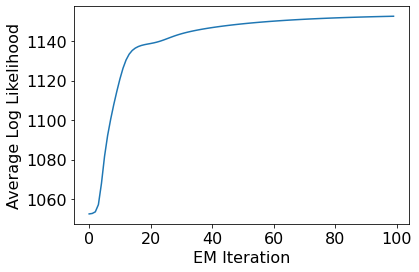

In [12]:
varying_model = varying_run_EM_and_plot(X, 100)

MSE :0.0002132796120632673
Examples:
True:


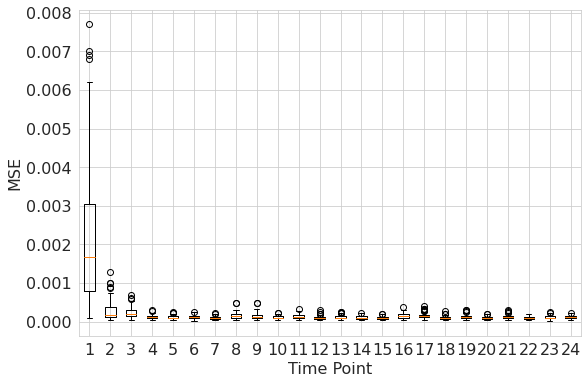

<Figure size 7200x3600 with 0 Axes>

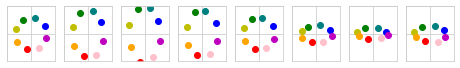

Reconstructed:


<Figure size 7200x3600 with 0 Axes>

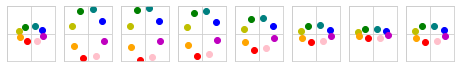

True:


<Figure size 7200x3600 with 0 Axes>

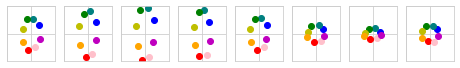

Reconstructed:


<Figure size 7200x3600 with 0 Axes>

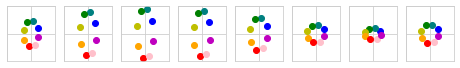

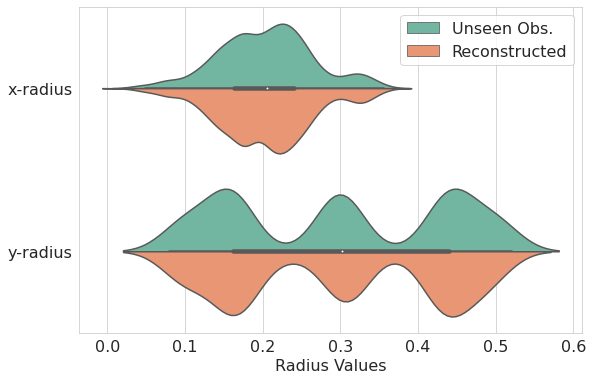

In [23]:
# Reconstruction
test_recons = varying_model.reconstruct(test_obs)
test_recons = test_recons[1:]
test_obs = test_obs[1:]
MSEs = np.mean(((test_obs-test_recons)**2), axis=2)
box_plots(MSEs)
print("MSE :" + str(np.mean(MSEs)))
print("Examples:")
print("True:")
plot_obs(test_obs[-1])
print("Reconstructed:")
plot_obs(test_recons[-1])
print("True:")
plot_obs(test_obs[2])
print("Reconstructed:")
plot_obs(test_recons[2])

# radius
test_rads = get_radius(test_obs)
recon_rads = get_radius(test_recons)
violin_radius(test_rads, recon_rads, "Unseen Obs.", "Reconstructed")

x_radius:
0.9847497965238504


Text(0, 0.5, 'Reconstruction')

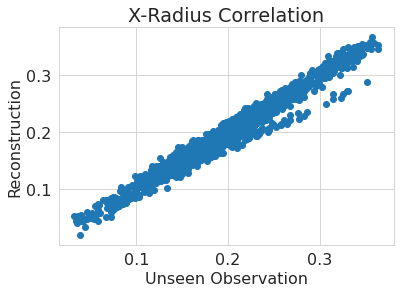

In [16]:
# X radius
print("x_radius:")
corr, _ = pearsonr(test_rads[:,0], recon_rads[:,0])
print(corr)
plt.scatter(test_rads[:,0], recon_rads[:,0])
plt.title('X-Radius Correlation')
plt.xlabel('Unseen Observation')
plt.ylabel('Reconstruction')

y_radius:
0.9889811852010802


Text(0, 0.5, 'Reconstruction')

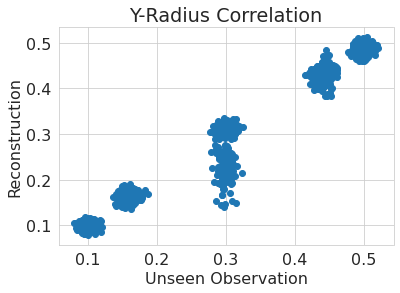

In [17]:
print("y_radius:")
corr, _ = pearsonr(test_rads[:,1], recon_rads[:,1])
print(corr)
plt.scatter(test_rads[:,1], recon_rads[:,1])
plt.title('Y-Radius Correlation')
plt.xlabel('Unseen Observation')
plt.ylabel('Reconstruction')

Generating samples...
(100, 24)
Sample error:0.0021391557421369537
0.04002005282050648


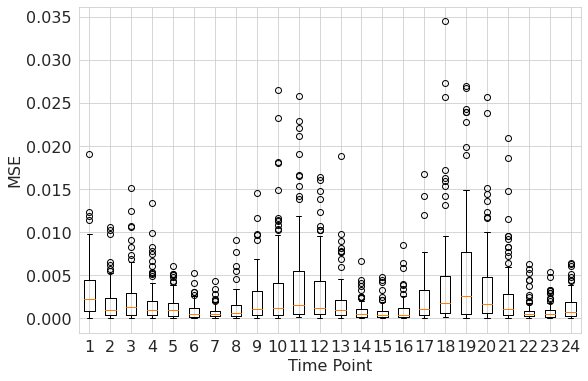

<Figure size 7200x3600 with 0 Axes>

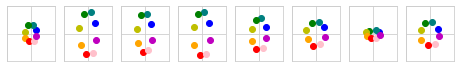

<Figure size 7200x3600 with 0 Axes>

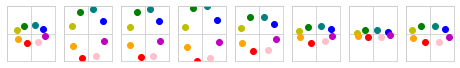

<Figure size 7200x3600 with 0 Axes>

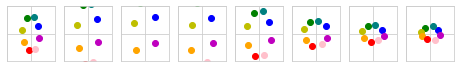

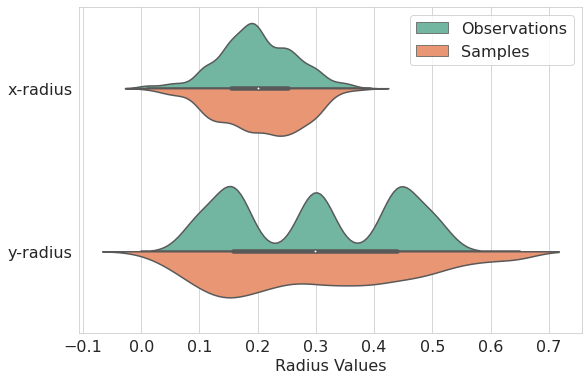

In [24]:
# Sample
print("Generating samples...")
num_samples = 100
samples = []
for i in range(num_samples):
    (states_sample, obs_sample) = varying_model.sample(T)
    samples.append(obs_sample)
samples = np.array(samples)

sample_MSE = sample_accuracy(samples)
print(sample_MSE.shape)
print("Sample error:" +str(np.mean(sample_MSE)))
box_plots(sample_MSE)

print(np.mean((samples-np.zeros(samples.shape))**2))

# Plot some
plot_obs(samples[0])
plot_obs(samples[1])
plot_obs(samples[2])

# Samples
rep_data = X = generate_ellipse_data(samples.shape[0], samples.shape[1], period, plot=False)
x_rads = get_radius(rep_data)
samples_rads = get_radius(samples)
violin_radius(x_rads, samples_rads, "Observations", "Samples")


8.33%
0.0002774909741109629
Example:


<Figure size 7200x3600 with 0 Axes>

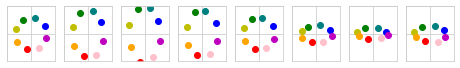

<Figure size 7200x3600 with 0 Axes>

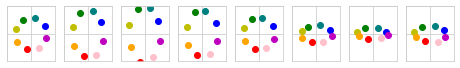

16.6%
0.00028890252138566214
Example:


<Figure size 7200x3600 with 0 Axes>

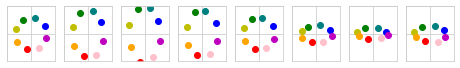

<Figure size 7200x3600 with 0 Axes>

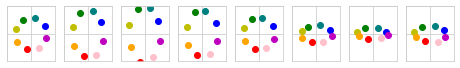

25.0%
0.0002450609214871441
Example:


<Figure size 7200x3600 with 0 Axes>

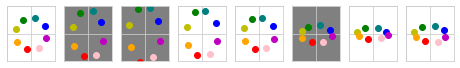

<Figure size 7200x3600 with 0 Axes>

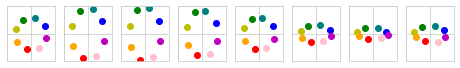

33.3%
0.0003920804511659866
Example:


<Figure size 7200x3600 with 0 Axes>

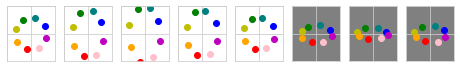

<Figure size 7200x3600 with 0 Axes>

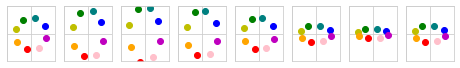

41.6%
0.00045968467600064595
Example:


<Figure size 7200x3600 with 0 Axes>

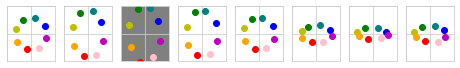

<Figure size 7200x3600 with 0 Axes>

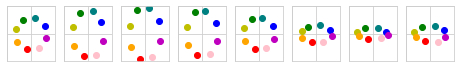

50.0%
0.000539952942041291
Example:


<Figure size 7200x3600 with 0 Axes>

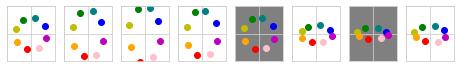

<Figure size 7200x3600 with 0 Axes>

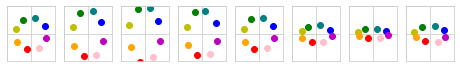

58.3%
0.0005180076290402827
Example:


<Figure size 7200x3600 with 0 Axes>

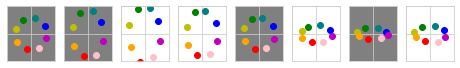

<Figure size 7200x3600 with 0 Axes>

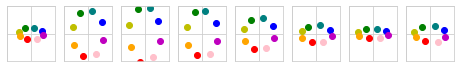

66.6%
0.0005749513065021318
Example:


<Figure size 7200x3600 with 0 Axes>

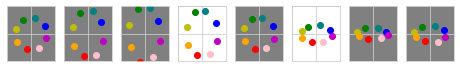

<Figure size 7200x3600 with 0 Axes>

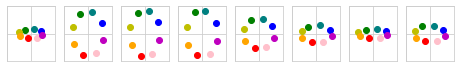

75.0%
0.0006891723401048795
Example:


<Figure size 7200x3600 with 0 Axes>

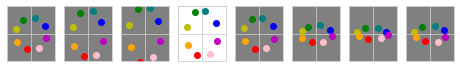

<Figure size 7200x3600 with 0 Axes>

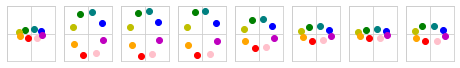

83.3%
0.001418180551108082
Example:


<Figure size 7200x3600 with 0 Axes>

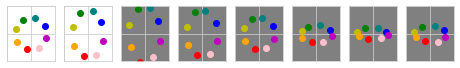

<Figure size 7200x3600 with 0 Axes>

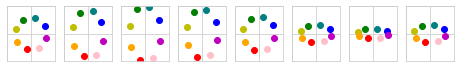

91.6%
0.002811204504146025
Example:


<Figure size 7200x3600 with 0 Axes>

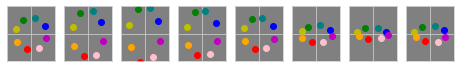

<Figure size 7200x3600 with 0 Axes>

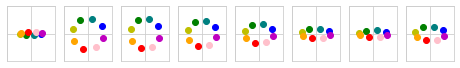

Text(0, 0.5, 'Imputed Values MSE')

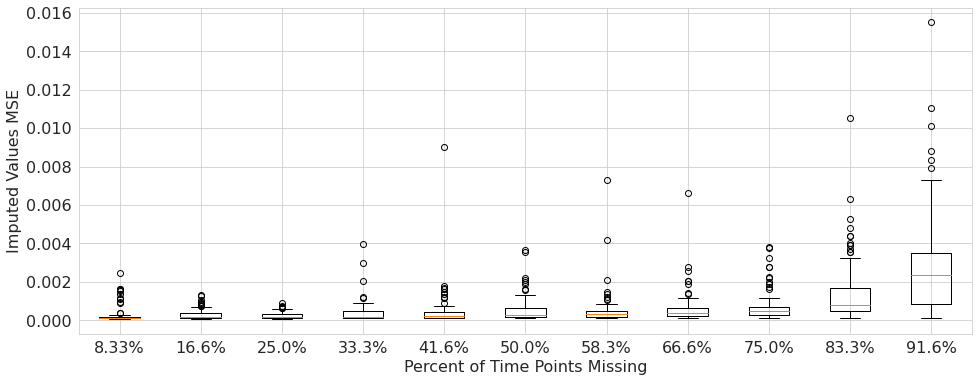

In [80]:
# Impute
MSEs = []
percents = []
for amount_missing in range(2, test_obs.shape[1], 2):
    
    masked_test = np.ma.asarray(test_obs)
    true = np.copy(masked_test)
    for n_ix in range(test_obs.shape[0]):
        ix = np.random.choice(test_obs.shape[1], size=amount_missing, replace=False)
        masked_test[n_ix, ix] = np.ma.masked
    mask = np.ma.getmask(masked_test)
    imputed = varying_model.reconstruct(masked_test)
    target = true[mask].reshape(test_obs.shape[0], int(np.sum(mask)/test_obs.shape[0]))
    predicted = imputed[mask].reshape(test_obs.shape[0], int(np.sum(mask)/test_obs.shape[0]))
    MSE = np.mean((target-predicted)**2, axis = -1)[1:]
    MSEs.append(MSE)
    percents.append(str(amount_missing*100/test_obs.shape[1])[:4]+'%')
    print(percents[-1])
    print(np.mean(MSE))
    print("Example:")
    new_obs = np.copy(test_obs)
    for n_index in range(test_obs.shape[0]):
        for t_index in range(test_obs.shape[1]):
            for index in range(test_obs.shape[2]):
                if mask[n_index][t_index][index]:
                    new_obs[n_index][t_index][index] = imputed[n_index][t_index][index] 
    plot_obs(test_obs[-1], mask[-1])
    plot_obs(new_obs[-1])
    
fig = plt.figure(1, figsize=(16, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(MSEs)
ax.set_xticklabels(percents)
plt.xlabel("Percent of Time Points Missing")
plt.ylabel("Imputed Values MSE")